# Lab 10

## Continuing Seaborn
We'll finish up the seaborn material from last lab

## Multidimensional Scaling (MDS)
*Note:* This is based off of [Prof Tony Jebara's lecture notes for COMS 6772 at Columbia in Spring 2015.](http://www.cs.columbia.edu/~jebara/6772/notes/notes2.pdf) 

Say we have a series of points $x_1,\ldots,x_n \in R^d$, where $d$ is large, and we want to learn a representation of these data in $R^k$ with $k << d$ (as we do in Project 2 to visualize Presidents and speeches).

How can we do this?

Idea: Find a representation that preserves **pairwise distances** between the data. In general we don't need to just consider distances, but can widen our scope to dissimilarities. A **Dissimilarity** is a function $d:R^d \times R^d \to R$ such that for all $x,y \in R^d$.

- $d(x,y) \geq 0$
- $d(x,x) = 0$
- $d(x,y) = d(y,x)$

Two examples which are both distances and dissimilarities are the usual Euclidean distance between vectors and the Jensen-Shannon distance for distributions.

For our data $x_1,\ldots,x_n$, we can construct the matrix of pairwise dissimilarities as 
$$\Delta_{ij} = d(x_i, x_j)$$

Now we can formalize the problem a bit more. Given data $x_1,\ldots,x_n \in R^d$ with dissimilarity matrix $\Delta$, can we find a representation $y_1,\ldots,y_n \in R^k$ with dissimilarity matrix $D$ such that $D$ is "close" to $\Delta$.

How do we define "close"? [Scikit learn](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html) uses **Stress**:

$$Stress(y_1,\ldots,y_n) = \sum_{ij} (D_{ij} - \Delta_{ij})^2$$

To find a lower-dimensional representation we then find $y_1,\ldots,y_n \in R^k$ to minimize the stress.

Let's look at an example with the NFL trends data from Lab 9.

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

In [4]:
# load the data
nfl_trends = pd.read_csv("data/fivethirtyeight-nfl-google.csv", header=1)
nfl_trends.head()
# convert percent strings into floats
numeric_data = (nfl_trends.iloc[:,1:]
                .replace("%", "",regex=True)
                .astype(float))
numeric_data["DMA"] = nfl_trends["DMA"]
nfl_trends = numeric_data

We'll normalize the search interest for each league in each market (they're actually close to adding up to 100 except for rounding errors).

In [14]:
# get the search interest for each league, normalizes
interests  = nfl_trends.iloc[:,:-2].values
interests = interests / interests.sum(1, keepdims=True)

Now we can compute the Jensen-Shannon distance between all of the markets and get a distance matrix.

In [17]:
from scipy.stats import entropy

def JSdiv(p, q):
    """Jensen-Shannon divergence."""
    m = (p + q) / 2
    return (entropy(p, m, base=2.0) + entropy(q, m, base=2.0)) / 2

In [20]:
# initialize the distance matrix
n = interests.shape[0]
dist = np.zeros((n,n))
# compute JS distance for all pairs
for i in range(n):
    for j in range(n):
        dist[i,j] = JSdiv(interests[i,:], interests[j,:])

And use MDS to find a lower dimensional representation

In [63]:
from sklearn import manifold

# intiialize
MDS =  manifold.MDS(dissimilarity="precomputed")
# transform to lower dimensional representation with JS distance
lower = MDS.fit_transform(dist)

# intiialize
MDS =  manifold.MDS()
# transform to lower dimensional representation with Euclidean distance
lower_naive = MDS.fit_transform(interests)

/home/ebenmichael/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


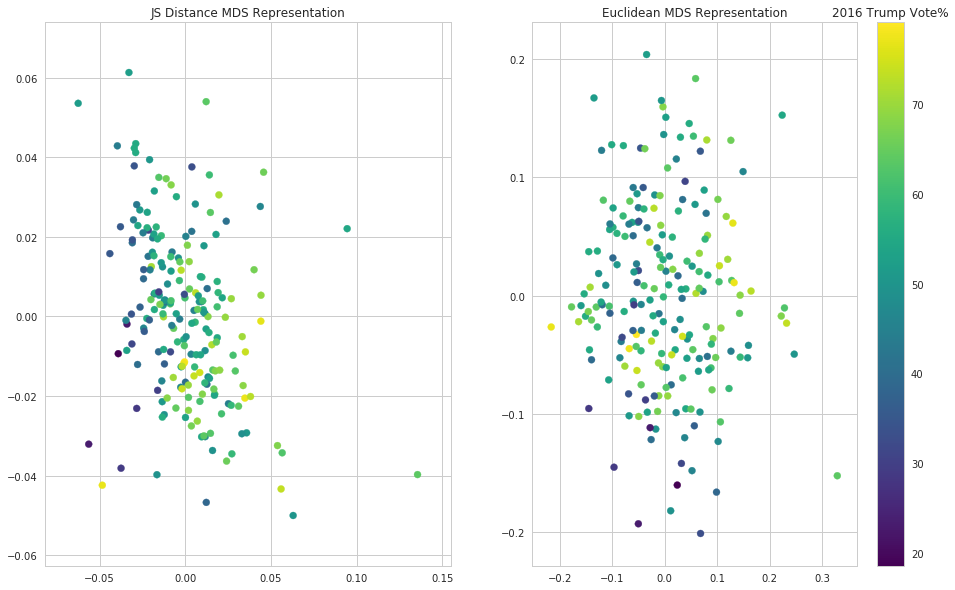

In [68]:
# put into a dataframe and plot
lower_df = pd.DataFrame({"x_JS":lower[:,0], "y_JS":lower[:,1],
                         "x_naive":lower_naive[:,0], "y_naive": lower_naive[:,1],
                         "DMA":nfl_trends["DMA"], 
                        "Trump 2016 Vote%":nfl_trends["Trump 2016 Vote%"]})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,10))
s = ax1.scatter(lower_df["x_JS"], lower_df["y_JS"], c=lower_df["Trump 2016 Vote%"],
           cmap=plt.get_cmap("viridis"))
s = ax2.scatter(lower_df["x_naive"], lower_df["y_naive"], c=lower_df["Trump 2016 Vote%"],
           cmap=plt.get_cmap("viridis"))

ax1.set_title("JS Distance MDS Representation")
ax2.set_title("Euclidean MDS Representation")

cbar = fig.colorbar(s)
cbar.ax.set_title("2016 Trump Vote%");